In [2]:
from collections import defaultdict
from iteration_utilities import deepflatten
from pandas import read_csv
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
import torch

# Load labelled mass and weight instances
data = read_csv('../data/edited_data.csv')

# Filter records with 'en masse' due to negligible sample size (2 instances)
filtered = data[data.Sense != 'Q']

# Split data for cross validation without data leakage
X_train, X_test, y_train, y_test = train_test_split(
    filtered, filtered.Sense,
    test_size=.2, random_state=153, stratify=filtered.Sense
)

# Extract sentences, keyword tokens, and word keyword senses
sentences_train = list(X_train[['Context before', 'token', 'Context after']].agg(' '.join, axis=1))
keywords_train = list(X_train.token)
senses_train = list(y_train)
sentences_test = list(X_test[['Context before', 'token', 'Context after']].agg(' '.join, axis=1))
keywords_test = list(X_test.token)
senses_test = list(y_test)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MacBERTh tokenizer and model (PyTorch). Set the model to evaluation mode.
macberth = AutoModel.from_pretrained('emanjavacas/MacBERTh').to(device)
macberth.eval()
tokenizer = AutoTokenizer.from_pretrained('emanjavacas/MacBERTh')

# Generate sentence embeddings
with torch.no_grad():
    ids_train = tokenizer(sentences_train, return_tensors='pt', padding=True).to(device)
    output_train = macberth(**ids_train)

Some weights of the model checkpoint at emanjavacas/MacBERTh were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# Return the index of the keyword
def get_keyword_idx (ids, tokenizer, keyword):
    subwords = tokenizer.convert_ids_to_tokens(ids)
    for idx, subword in enumerate(subwords):
        if keyword in subword:
            return idx

# Retreive the keyword indexes
target = []
for idx, keyword in enumerate(keywords_train):
    target.append(get_keyword_idx(ids_train.input_ids[idx], tokenizer, keyword))

# Retreive the keyword embeddings
np_arr = output_train['last_hidden_state'].cpu().detach().numpy()
embeddings_train = []
for i in list(range(len(np_arr))):
    embeddings_train.append(np_arr[i][target[i]].tolist())

In [4]:
# Generate sentence embeddings
with torch.no_grad():
    ids_test = tokenizer(sentences_test, return_tensors='pt', padding=True).to(device)
    output_test = macberth(**ids_test)

# Retreive the keyword indexes
target = []
for idx, keyword in enumerate(keywords_test):
    target.append(get_keyword_idx(ids_test.input_ids[idx], tokenizer, keyword))

# Retreive the keyword embeddings
np_arr = output_test['last_hidden_state'].cpu().detach().numpy()
embeddings_test = []
for i in list(range(len(np_arr))):
    embeddings_test.append(np_arr[i][target[i]].tolist())

/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


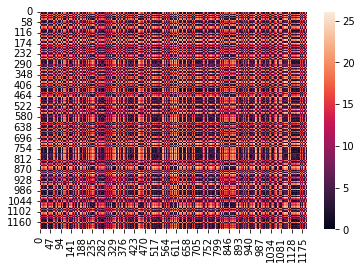

<AxesSubplot:>

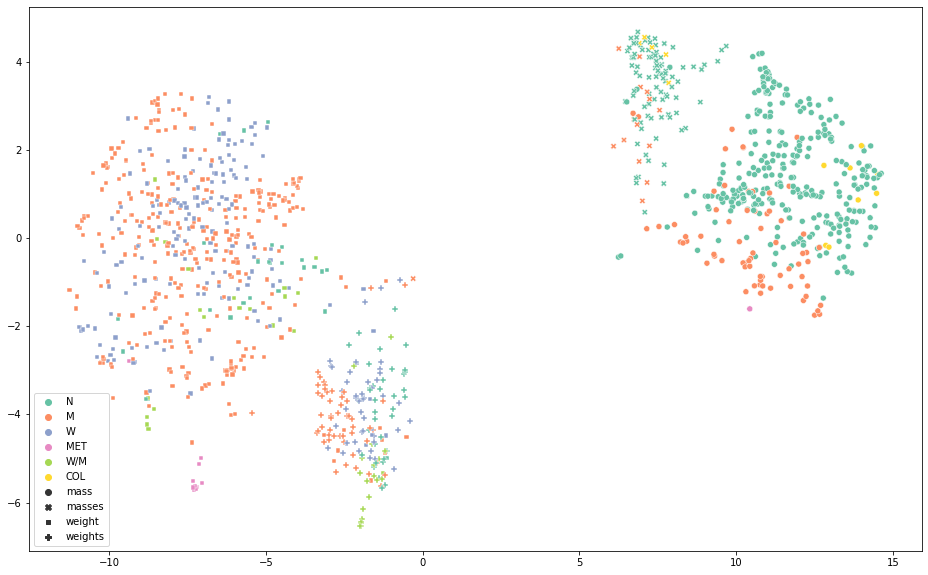

In [5]:
from matplotlib.pylab import figure, show
from seaborn import color_palette, heatmap, scatterplot
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import sys

pca_embeddings = PCA(n_components=50).fit_transform(embeddings_train)
tsne_embeddings = TSNE(perplexity=250, init='pca', random_state=153).fit_transform(pca_embeddings)

distance = pairwise_distances(tsne_embeddings)
ax = heatmap(distance)
show()

figure(figsize=(16,10))
scatterplot(
    x=tsne_embeddings[:,0], y=tsne_embeddings[:,1],
    style=keywords_train,
    hue=senses_train,
    palette=color_palette('Set2', len(set(senses_train))),
    legend="full",
)

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skopt import BayesSearchCV

inner_cv = StratifiedKFold(n_splits=13, random_state=153, shuffle=True)
outer_cv = StratifiedKFold(n_splits=13, random_state=153, shuffle=True)

pipe_svm = make_pipeline(StandardScaler(), LinearSVC(dual=True, random_state=153))

pipe_svm.get_params().keys()

opt_svm = BayesSearchCV(
	pipe_svm,
	{'linearsvc__C': (1e-6, 1e+6, 'log-uniform'),
   'linearsvc__tol': (1e-6, 1e+6, 'log-uniform')},
	cv=inner_cv
)

opt_svm.fit(embeddings_train, senses_train)
# print("val. score: %s" % opt_svm.best_score_)
# print("test score: %s" % opt_svm.score(embeddings_test, senses_test))
# print("best params: %s" % str(opt_svm.best_params_))
# scores = cross_val_score(opt_svm, embeddings_train, senses_train, cv=outer_cv)

# print(scores)
# print(scores.mean())
# print(scores.std())

# clf = make_pipeline(StandardScaler(), LinearSVC(random_state=153, C=opt_svm.best_params_['linearsvc__C']))
# clf.fit(X_train, y_train)
# print(clf.score(X_test, y_test))
# scores = cross_val_score(clf, embeddings_train, senses_train, cv=14)
# print(scores)
# print(scores.mean())
# print(scores.std())

# clf = KNeighborsClassifier(n_neighbors=3)
# scores = cross_val_score(clf, X_train, y_train, cv=10)
# print(scores)
# print(scores.mean())
# print(scores.std())
# clf.fit(X_train, y_train)
# print(clf.score(X_test, y_test))

/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

BayesSearchCV(cv=StratifiedKFold(n_splits=13, random_state=153, shuffle=True),
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('linearsvc',
                                         LinearSVC(random_state=153))]),
              search_spaces={'linearsvc__C': (1e-06, 1000000.0, 'log-uniform'),
                             'linearsvc__tol': (1e-06, 1000000.0,
                                                'log-uniform')})

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=13, random_state=153, shuffle=True)

for train, test in cv.split(embeddings_train, y_train):
    print(y_train.iloc[list(test)].value_counts())
    # print('train -  {}   |   test -  {}'.format(np.bincount(senses_train[train]), np.bincount(senses_train[test])))